In [1]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import scipy.stats

from analysis import load_events, filter_events

In [2]:
events = load_events("../../data/2024-11-20_23-29-01-chickpea/logs_2024-11-21_09-31-26_735810.txt")

Start time: 1732174279.629088


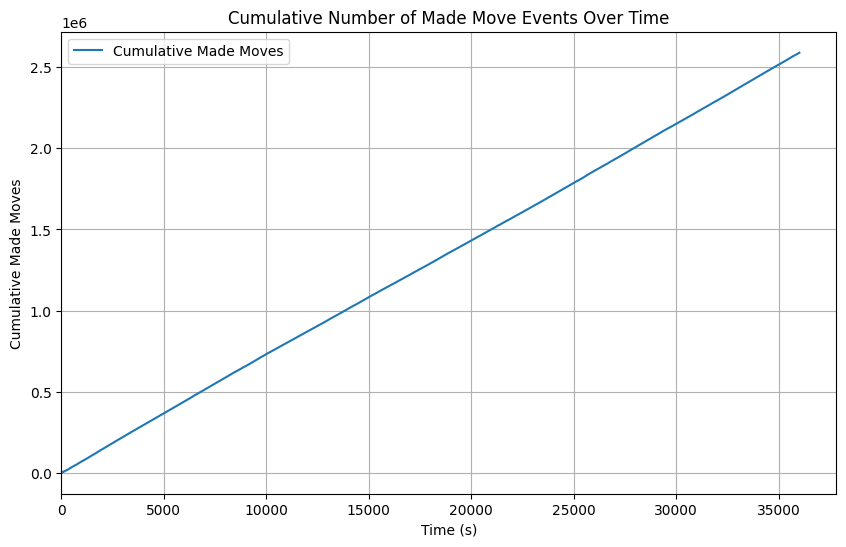

Time to first move: 15.621576070785522


In [3]:
timestamps = [event[0] for event in events if event[1] == "made_move"]
cumulative_made_moves = list(range(1, len(timestamps) + 1))

plt.figure(figsize=(10, 6))
plt.plot(timestamps, cumulative_made_moves, label='Cumulative Made Moves')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Made Moves')
plt.title('Cumulative Number of Made Move Events Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()

print(f"Time to first move: {min(timestamps)}")

In [4]:
print("Number of moves", max(cumulative_made_moves))

Number of moves 2589902


In [5]:
# What percent of time is the GPU thread being used?

total_duration = 0
total_evaluated = 0
for event in events:
    if event[1] == "gpu_evaluation":
        total_duration += event[2]["duration"]
        total_evaluated += event[2]["batch_size"]

evaluations = [event[0] for event in events if event[1] == "gpu_evaluation"]
print("percent GPU utilization:", total_duration / (max(evaluations) - min(evaluations)))

percent GPU utilization: 0.8133956469284541


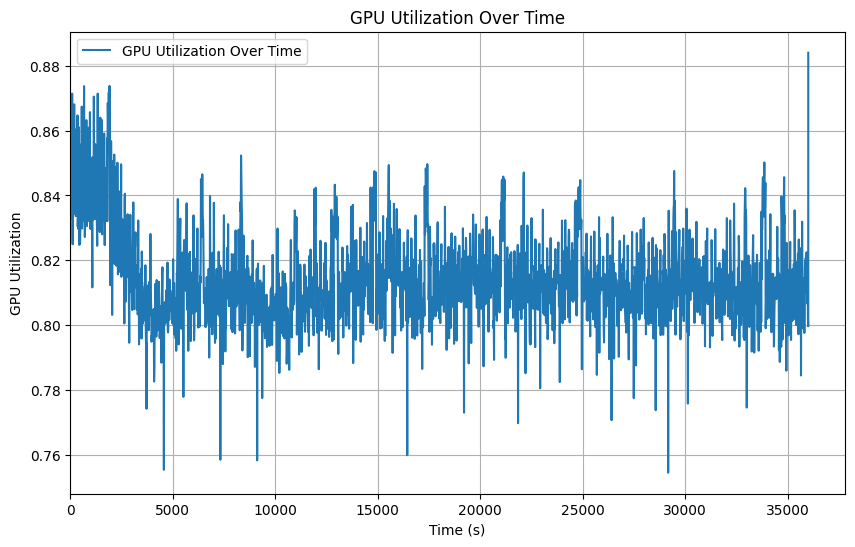

In [6]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

gpu_utilization = []
times = []

window_size = 1000

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    time_interval = evaluations_in_window[-1][0] - evaluations_in_window[0][0]
    duration = sum(event[2]["duration"] for event in evaluations_in_window)

    gpu_utilization.append(duration / time_interval)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.plot(times, gpu_utilization, label='GPU Utilization Over Time')
plt.xlabel('Time (s)')
plt.ylabel('GPU Utilization')
plt.title('GPU Utilization Over Time')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.show()


/var/folders/np/v76cnj490z525wk67wqh68dc0000gn/T/ipykernel_45120/532304626.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


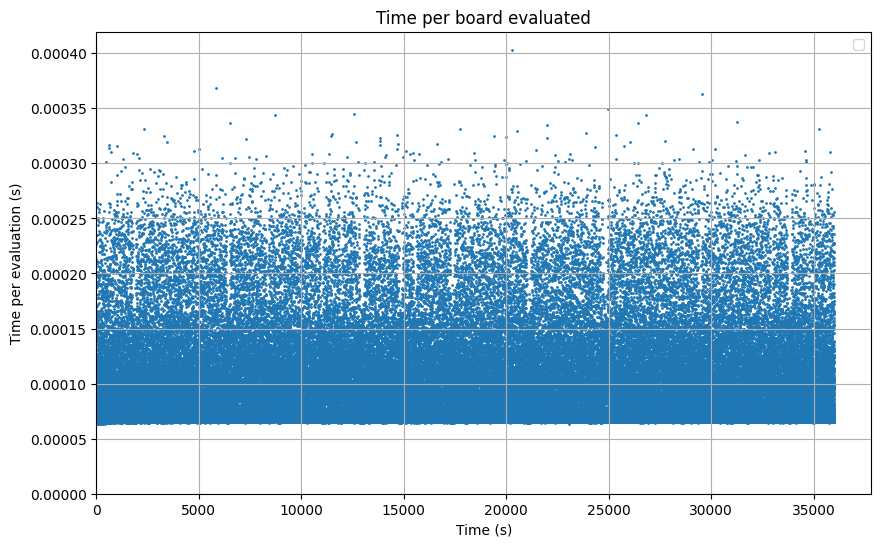

In [7]:
evaluations = [event for event in events if event[1] == "gpu_evaluation"]

time_per_evaluation = []
times = []

window_size = 10

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    duration = sum(event[2]["duration"] for event in evaluations_in_window)
    total_evaluations = sum(event[2]["batch_size"] for event in evaluations_in_window)

    time_per_evaluation.append(duration / total_evaluations)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.scatter(times, time_per_evaluation, s=1)
plt.xlabel('Time (s)')
plt.ylabel('Time per evaluation (s)')
plt.title('Time per board evaluated')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()


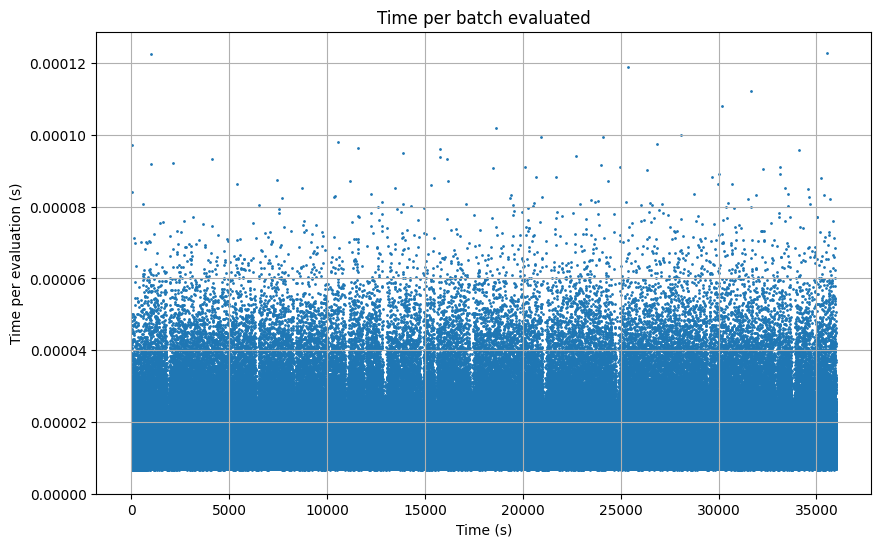

In [8]:
evaluations = [
    event for event in events if (
        event[1] == "gpu_evaluation"
        # and event[0] > 39650
        # and event[0] < 38125
    )
]

time_per_evaluation = []
times = []

window_size = 1

i = 0
while True:
    evaluations_in_window = evaluations[i:i + window_size]
    if not evaluations_in_window:
        break

    duration = sum(event[2]["duration"] for event in evaluations_in_window)
    number_of_evaluations = len(evaluations_in_window)

    time_per_evaluation.append(duration / total_evaluations)
    times.append(evaluations_in_window[-1][0])

    i += window_size

plt.figure(figsize=(10, 6))
plt.scatter(times, time_per_evaluation, s=1)
plt.xlabel('Time (s)')
plt.ylabel('Time per evaluation (s)')
plt.title('Time per batch evaluated')
plt.grid(True)
# plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()


In [9]:
# What is the average batch size?

batch_sizes = [event[2]["batch_size"] for event in events if event[1] == "gpu_evaluation"]
sum(batch_sizes) / len(batch_sizes)

128.0

Slope: 3.3120997059481185
Intercept: -109.09278150395403
R-squared: 0.999775276920784


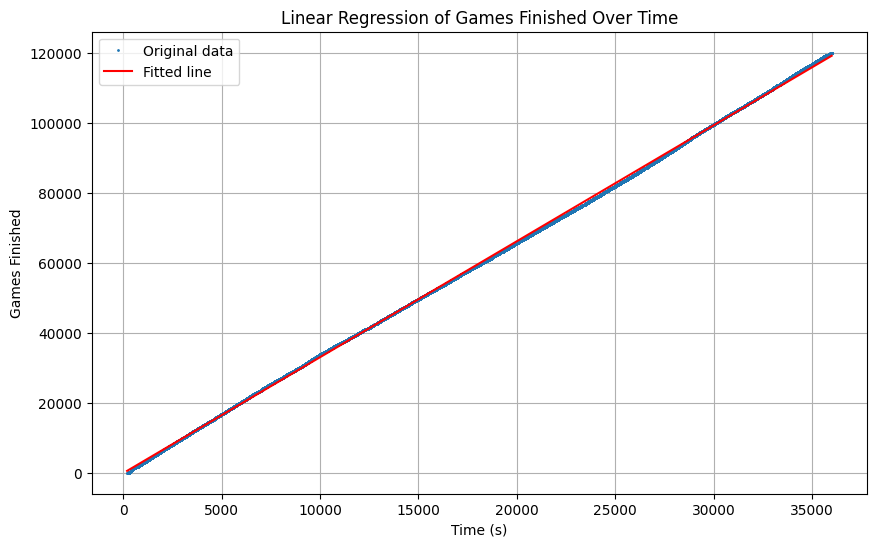

In [10]:
# Prepare the data for linear regression
x = [event[0] for event in events if event[1] == "game_end"]
y = range(len(x))

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original data', markersize=1)  # Made the dots smaller by reducing markersize
plt.plot(x, [slope * xi + intercept for xi in x], 'r', label='Fitted line')
plt.xlabel('Time (s)')
plt.ylabel('Games Finished')
plt.title('Linear Regression of Games Finished Over Time')
plt.legend()
plt.grid(True)
plt.show()